# Data Exploration

In [66]:
import pandas as pd 
import matplotlib
from matplotlib import pyplot as plt
import random


## read data set 

In [21]:
df = pd.read_csv('/home/orangebacked/Documents/applications/ibm-auto-robot/data/trainingset_devices11.csv')

df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


## mini feature engineering

In [50]:
# attributes 1-9 are bytes so I will read them as strings
for bytelist in list(df.columns)[3:]:
    df[bytelist] = df[bytelist].astype(str)

# transform date into date object
df['date'] = pd.to_datetime(df.date)

# for the sake of aggregation
df['ones'] = 1 

# Data exploration questions

## 1. how are the devices distributed in the database?

In [85]:
distribution_dev

,ones
device,
Z1F0GB8A,304
W1F0JY02,304
W1F0G9T7,304
S1F0FP0C,304
W1F0FZPA,304
...,...
Z1F0L7NS,5
Z1F0L7M8,5
S1F04KSC,4


(array([433.,  49., 190., 127.,  25.,  15.,  22., 139.,  38., 131.]),
 array([  1. ,  31.3,  61.6,  91.9, 122.2, 152.5, 182.8, 213.1, 243.4,
        273.7, 304. ]),
 <BarContainer object of 10 artists>)

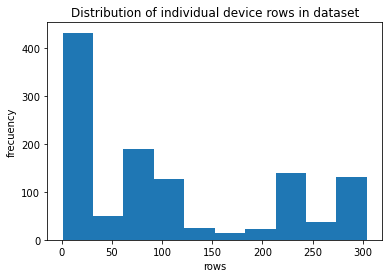

In [87]:
distribution_dev = pd.DataFrame(df.groupby('device').count()['ones']).sort_values(by=['ones'], ascending=False)
plt.title('Distribution of individual device rows in dataset')
plt.xlabel('rows')
plt.ylabel('frecuency')
plt.hist(distribution_dev['ones'])

The data shows that devices within the dataset follow a distribution, that entails that the devices that are more common in the dataset will be skewed towards these devices if this number is considerable; moreover, the maximum value a device is mentioned in the data is 300 which represents roughly .24 percent of the data. Therefore, we can assume its influence is negligible. Nonetheless there is a high frequency of devices only mentioned once. Are these new devices that haven't yet failed or have comunication problems and are serviced manually?

## 2. how are failures distributed (there is probably an imbalance)?

In [93]:
# ok interesting
df.groupby('device').sum()['failure'].unique()

array([0, 1])

ok this is very interesing, there is no device that has failed twice

In [98]:
failure_by_device = df.groupby('device').sum()
failure_by_device[failure_by_device['failure'] ==0]

,failure,ones
device,,
S1F01085,0,6
S1F013BB,0,6
S1F0166B,0,6
S1F01E6Y,0,48
S1F01JE0,0,6
...,...,...
Z1F1RE71,0,6
Z1F1VMZB,0,292
Z1F26YZB,0,84


In [99]:
failure_by_device = df.groupby('device').sum()
failure_by_device[failure_by_device['failure'] ==1]

,failure,ones
device,,
S1F023H2,1,19
S1F03YZM,1,215
S1F09DZQ,1,199
S1F0CTDN,1,7
S1F0DSTY,1,45
...,...,...
Z1F1901P,1,132
Z1F1AG5N,1,9
Z1F1FCH5,1,19


there is 10 times more devices that haven't failed that those that have failed, let us check the time the devices have been in the data to check our hypothesis that they are new devices, since we do not know when the device started to be used, and there is no continuous data of the iot device, I will start checking when it was registered in the data base.

In [176]:
df_failed_dev = df[df['device'].isin(list(df[df['failure'] == 1]['device']))]
df_not_failed_dev = df[df['device'].isin(list(df[df['failure'] == 0]['device']))]

In [122]:
df.

124494

In [159]:
# time to failure
df_failed_dev[df_failed_dev['failure'] == 1]['device'][4885]
datelist = list(df[df['device'] == 'S1F0RRB1'].sort_values(by=['date']).date)
time_delta = datelist[-1] - datelist[0]



days_to_fail = []
for device in list(df_failed_dev[df_failed_dev['failure'] == 1]['device']):
    datelist = list(df[df['device'] == device].sort_values(by=['date']).date)
    time_delta = datelist[-1] - datelist[0]
    days_to_fail.append(time_delta.days)
    

(array([26., 13.,  9.,  8., 21.,  6., 13.,  7.,  0.,  3.]),
 array([  4. ,  33.4,  62.8,  92.2, 121.6, 151. , 180.4, 209.8, 239.2,
        268.6, 298. ]),
 <BarContainer object of 10 artists>)

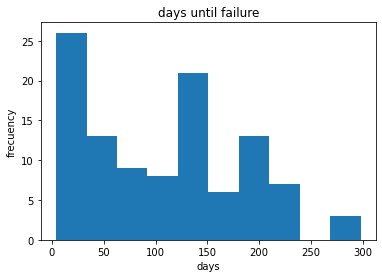

In [161]:
plt.title('days until failure')
plt.xlabel('days')
plt.ylabel('frecuency')
plt.hist(days_to_fail)

In [200]:
listss = list(df_not_failed_dev['device'])
random_devices = [listss[random.randint(0,124000)] for x in range(0,2000)]

days_not_failed = []
for device in random_devices:
    datelist = list(df[df['device'] == device].sort_values(by=['date']).date)
    time_delta = datelist[-1] - datelist[0]
    days_not_failed.append(time_delta.days)
    

(array([ 50.,  36., 246., 201.,  87.,  13.,  52., 659.,  16., 640.]),
 array([  4. ,  34.1,  64.2,  94.3, 124.4, 154.5, 184.6, 214.7, 244.8,
        274.9, 305. ]),
 <BarContainer object of 10 artists>)

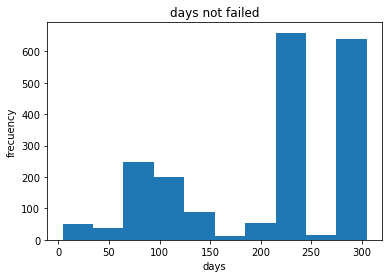

In [205]:
plt.title('days not failed')
plt.xlabel('days')
plt.ylabel('frecuency')
plt.hist(days_not_failed)

well there appears to be no correlation in the time since the first error was transmited and the probability of failure, so that hypothesis was wrong. Let us address the last question

## 3. is the time series stationary or does it exhibit seasonality?

In [219]:
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)

(array([25032., 19500., 19833., 12012., 11330., 10469., 10531.,  8346.,
         4470.,  2971.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

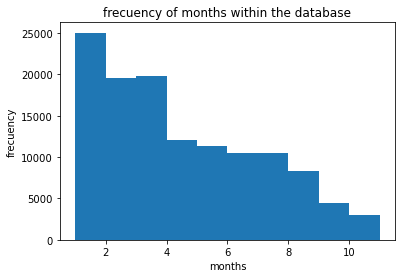

In [234]:
plt.title('frecuency of months within the database')
plt.xlabel('months')
plt.ylabel('frecuency')
plt.hist(df.month)

there seems to be a decreasing number of errors as time goes by which is strange 

(array([14161., 14052., 12871., 12740., 12340., 12098., 11814., 11555.,
        11260., 11603.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <BarContainer object of 10 artists>)

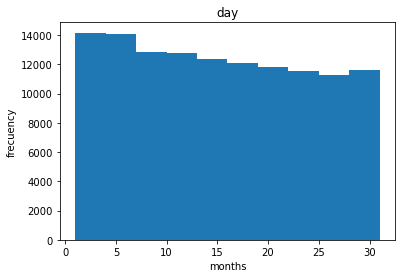

In [229]:
plt.title('day')
plt.xlabel('months')
plt.ylabel('frecuency')
plt.hist(df.day)

(array([24., 14.,  9.,  9., 21.,  6., 16.,  4.,  0.,  3.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

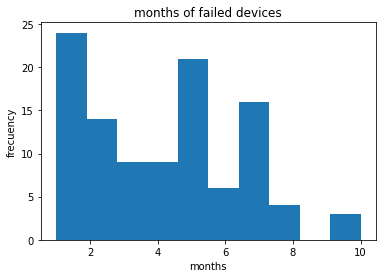

In [235]:
plt.title('months of failed devices')
plt.xlabel('months')
plt.ylabel('frecuency')
plt.hist(df[df['failure'] ==1].month)


(array([11., 10., 14.,  9.,  4., 23., 11.,  7., 11.,  6.]),
 array([ 2. ,  4.9,  7.8, 10.7, 13.6, 16.5, 19.4, 22.3, 25.2, 28.1, 31. ]),
 <BarContainer object of 10 artists>)

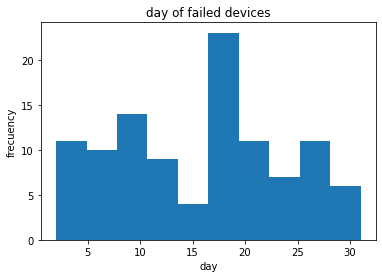

In [250]:
plt.title('day of failed devices')
plt.xlabel('day')
plt.ylabel('frecuency')
plt.hist(df[df['failure'] ==1].day)

there might be correlations with may and july within failed devices and this is an important feature to put in the model. Additionally, there seems to be a correlation in the day the failure happended so it would be an important feature to include in the model.

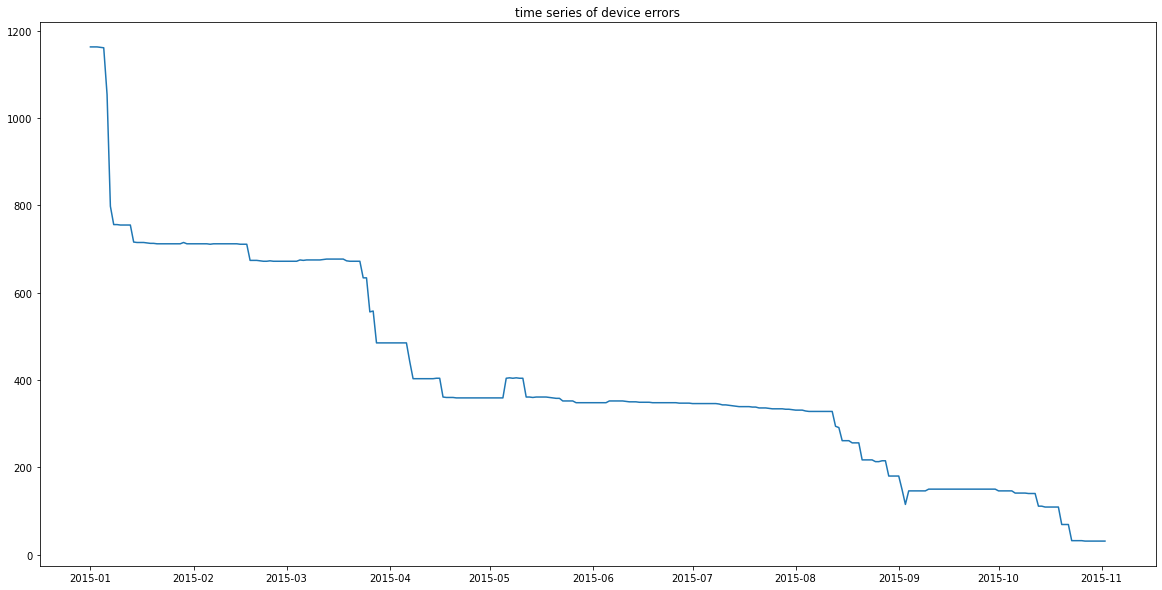

In [247]:

plt.figure(figsize=(20,10))
plt.title('time series of device errors')
plt.plot(df.groupby('date').sum().ones)